<a href="https://colab.research.google.com/github/jinyjib98/AI_Sprint_Project/blob/main/AI_05_%EA%B9%80%ED%98%95%EC%A7%84_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selected Data

## HR Analytics: Job Change of Data Scientists

Data Download
https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

<br/>

### Purpose of the analytics

**Predict who will move to a new job**

기업이 주최한 프로그램에 참여한 많은 사람들 중 진짜 데이터사이언티스트로의 이직을 고려하고 있는 사람을 찾는 것이 목적 

-> 기업 입장에서 Head Hunting 비용 절감 효과 + 이직에 관심있는 사람들의 특성을 파악하여 프로그램 내용 보완

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline

import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Section Project/Section2/Section2_Project_Data/aug_train.csv', sep=',')
test = pd.read_csv('/content/drive/MyDrive/Section Project/Section2/Section2_Project_Data/test.csv', sep=',')

In [ ]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
test = test.drop('Unnamed: 0', axis=1)
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21,1.0
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98,0.0
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15,1.0
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39,0.0
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72,1.0


In [ ]:
train.shape, test.shape

((19158, 14), (2129, 14))

In [ ]:
test_id = test['enrollee_id']

## EDA

### Features: 총 14개

- enrollee_id : Unique ID for candidate

- city: City code

- city_ development _index : Developement index of the city (scaled)

- gender: Gender of candidate

- relevent_experience: Relevant experience of candidate

- enrolled_university: Type of University course enrolled if any

- education_level: Education level of candidate

- major_discipline :Education major discipline of candidate

- experience: Candidate total experience in years

- company_size: No of employees in current employer's company

- company_type : Type of current employer

- last_new_job: Difference in years between previous job and current job

- training_hours: training hours completed

- target: 0 – Not looking for job change, 1 – Looking for a job change

<br/>

### Target feature
`target` feature를 모델의 타겟으로 선택

<br/>

- `target` value의 의미

 - 0: 이직 생각 없는 사람
 - 1: 이직 생각 있는 사람

<br/>

### 문제 유형

이직 생각 있는 사람(1) / 없는 사람(0)이라는 class로 데이터를 분류하여 예측하는 **'분류 문제'**

<br/>

### 성능 평가 지표 선택

In [ ]:
target = 'target'

y_baseline = train[target]

y_baseline.value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

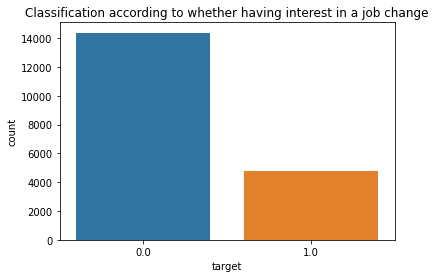

In [ ]:
sns.countplot(x=y_baseline)
plt.title("Classification according to whether having interest in a job change")
plt.show()

이 데이터는 이직 생각이 없는 사람으로 예측될 확률이 약 75%가 넘어가는 매우 **imbalanced data**

이런 경우, `accuracy score`외의 지표가 필요함

e.g.

- 사실 이직에 관심이 없는데, 이직에 관심이 있다고 잘못 예측된 사람의 수(FP)가 중요하면 `precision`
- 사실 이직에 관심이 있는데, 이직에 관심이 없다고 잘못 예측된 사람의 수(FN)가 중요하면 `recall`

<br/>

이번 데이터에서는 `precision`과 `recall`이 둘 다 고려되어야 하기 때문에 이 둘의 조화평균인 `f1 score`와 더불어, classification에 유용한 `ROC curve`,`AUC score`를 평가지표로 사용할 것

## EDA

In [ ]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21,1.0
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98,0.0
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15,1.0
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39,0.0
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72,1.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [ ]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

결측치 처리 해줘야 함!

#### feature 별 target 분포

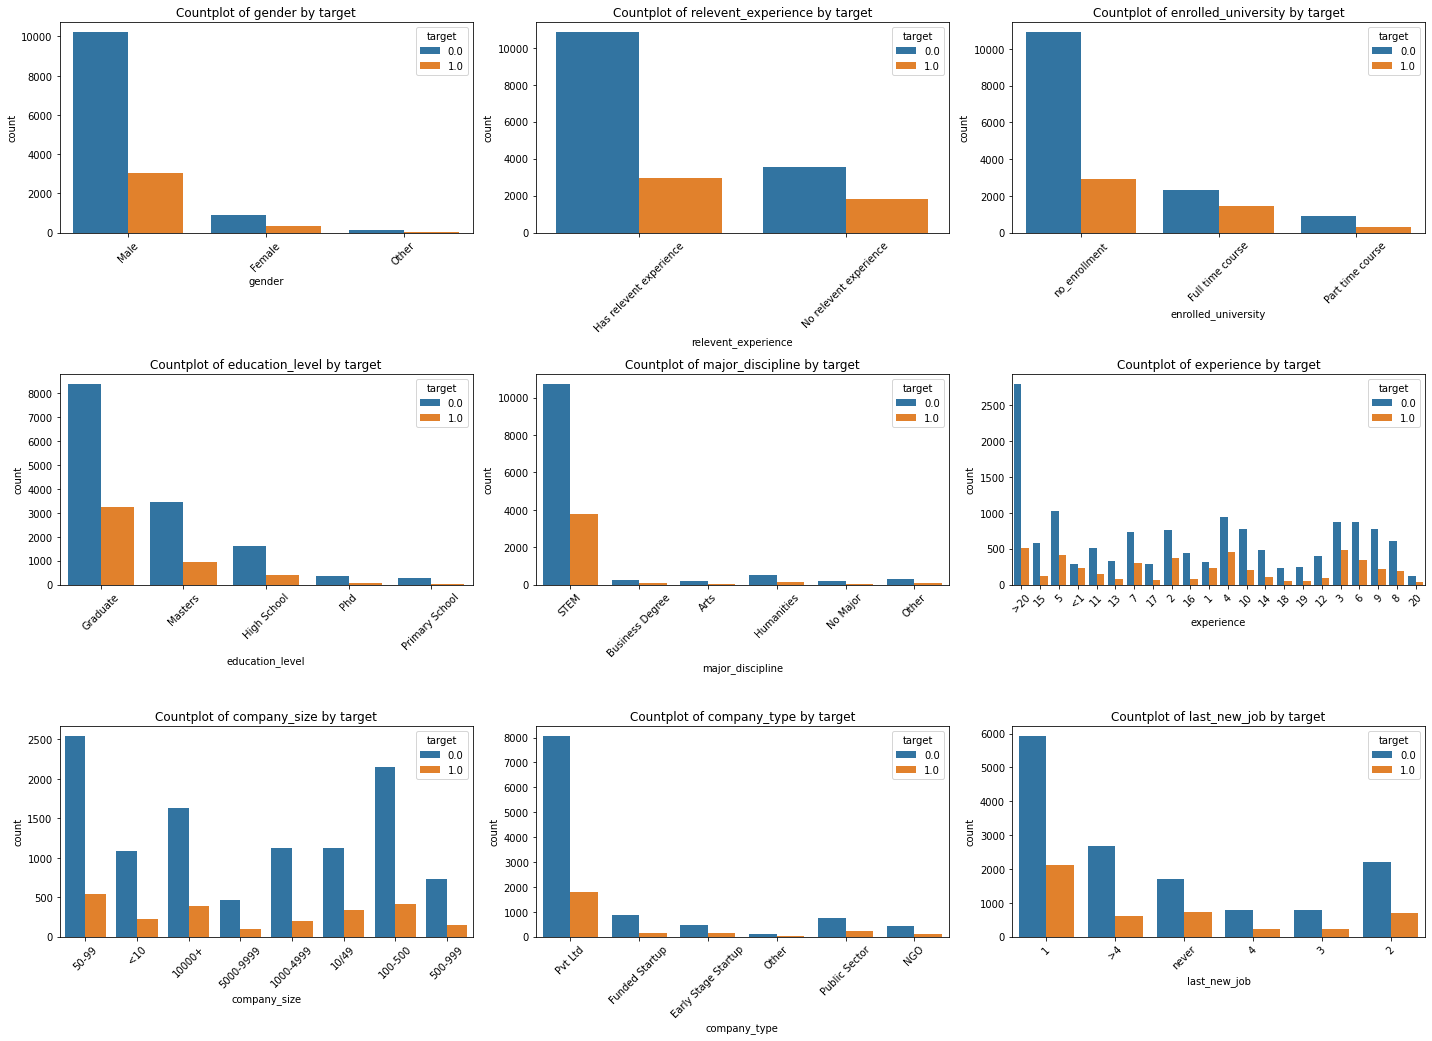

In [ ]:
plt.figure(figsize=[20,23])
feafures = ['gender','relevent_experience','enrolled_university','education_level','major_discipline',
       'experience','company_size','company_type','last_new_job']
n=1

for f in feafures:
    plt.subplot(5,3,n)
    sns.countplot(x=f, hue='target', data=train)
    plt.title("Countplot of {} by target".format(f))
    plt.xticks(rotation=45)
    n=n+1

plt.tight_layout()
plt.show()

비율은 상이하나, 전체적인 분포는 비슷함

-> 타겟 0의 비율이 월등히 높음

### feature 삭제 및 중복값 제거

데이터 분석을 위해서는 key 값으로 쓰인 `'enrollee_id'` feature를 제거해야 함

In [ ]:
train = train.drop('enrollee_id', axis=1)
test = test.drop('enrollee_id', axis=1)

`'enrollee_id'` feature 삭제로 인해 드러난 중복값은 없는지 확인

In [ ]:
print(f'train의 중복값 개수는 {train.duplicated().sum()}개 입니다.')
print(f'test의 중복값 개수는 {test.duplicated().sum()}개 입니다.')

train의 중복값 개수는 49개 입니다.
test의 중복값 개수는 1개 입니다.


중복값 삭제

In [ ]:
train = train.drop_duplicates()
test = test.drop_duplicates()

In [ ]:
print(f'train의 중복값 개수는 {train.duplicated().sum()}개 입니다.')
print(f'test의 중복값 개수는 {test.duplicated().sum()}개 입니다.')

train의 중복값 개수는 0개 입니다.
test의 중복값 개수는 0개 입니다.


### Train / Validation / Test set 분할

In [ ]:
train, val = train_test_split(train, train_size=0.8, random_state=2)

train.shape, val.shape, test.shape

((15287, 13), (3822, 13), (2128, 13))

### Encoding
categorical features -> numerical features

`experience`와 같이 숫자형임에도 '<' 같은 기호로 인해 문자로 취급되는 feature의 형태를 분석하기 쉽게 바꿔줄 것임

In [ ]:
train.describe(exclude='number').T.sort_values(by='unique', ascending=False)

,count,unique,top,freq
city,15287,123,city_103,3452
experience,15237,22,>20,2602
company_size,10567,8,50-99,2466
major_discipline,13027,6,STEM,11540
company_type,10390,6,Pvt Ltd,7834
last_new_job,14954,6,1,6429
education_level,14903,5,Graduate,9307
gender,11666,3,Male,10533
enrolled_university,14966,3,no_enrollment,10998
relevent_experience,15287,2,Has relevent experience,11000


In [ ]:
ordinal = OrdinalEncoder()

train.loc[:,'city'] = ordinal.fit_transform(train.loc[:,'city'])
val.loc[:,'city'] = ordinal.transform(val.loc[:,'city'])
test.loc[:,'city'] = ordinal.transform(test.loc[:,'city'])

Categorical data Encoding 방법 중 각 value에 순서를 정해서 encoding하는 `OrdinalEncoder()`를 사용할 것

우리가 사용할 모델인 RandomForest, XGBoost는 순서에 민감하지 않기 때문에 feature 수를 늘리지 않으면서, encoding이 가능한 OrdinalEncoder가 적합

### Handling Missing Values: Imputation

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Counts', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print (f"Your selected dataframe has {str(df.shape[1])} columns.\nThere are {str(mis_val_table_ren_columns.shape[0])} columns that have missing values.\n")
        
        return mis_val_table_ren_columns

In [ ]:
train_missing = missing_values_table(train)
val_missing = missing_values_table(val)
test_missing = missing_values_table(test)

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.



In [ ]:
train_missing

,Counts,% of Total Values
company_type,4897,32.0
company_size,4720,30.9
gender,3621,23.7
major_discipline,2260,14.8
education_level,384,2.5
last_new_job,333,2.2
enrolled_university,321,2.1
experience,50,0.3


In [ ]:
val_missing

,Counts,% of Total Values
company_type,1225,32.1
company_size,1200,31.4
gender,887,23.2
major_discipline,549,14.4
last_new_job,90,2.4
education_level,76,2.0
enrolled_university,65,1.7
experience,15,0.4


In [ ]:
test_missing

,Counts,% of Total Values
company_type,634,29.8
company_size,622,29.2
gender,508,23.9
major_discipline,312,14.7
education_level,52,2.4
last_new_job,40,1.9
enrolled_university,31,1.5
experience,5,0.2


missing values가 차지하는 비중이 크지 않은 `education_level`, `last_new_job`,  `enrolled_university`, `experience`의 결측치는 제거해도 데이터의 수에 큰 영향을 주지 않을 듯

In [ ]:
train.dropna(subset=['education_level', 'last_new_job', 'enrolled_university', 'experience'], inplace=True)
val.dropna(subset=['education_level', 'last_new_job', 'enrolled_university', 'experience'], inplace=True)
test.dropna(subset=['education_level', 'last_new_job', 'enrolled_university', 'experience'], inplace=True)


In [ ]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
train.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,1,0.878,Male,Has relevent experience,no_enrollment,Graduate,STEM,10,<10,Pvt Ltd,>4,218,0.0
1,2,0.698,Male,No relevent experience,Part time course,Graduate,STEM,4,NaN,NaN,2,7,1.0
2,3,0.884,Female,Has relevent experience,no_enrollment,Graduate,STEM,9,100-500,Pvt Ltd,2,54,0.0
3,4,0.836,NaN,Has relevent experience,no_enrollment,Graduate,STEM,19,10000+,Pvt Ltd,never,13,1.0
4,5,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,100-500,Pvt Ltd,4,39,0.0


나머지 feature의 경우에는 결측치의 비중이 전체 데이터의 10% 이상이므로, 무작정 제거하기 보다는 원래 데이터를 잘 반영하는 방향으로 채워주는 것이 더 좋을 듯

-> K-Nearest Neighbor Imputation: 근처에 있는 데이터들 중 더 많은 비율을 차지하는 value로 대체하는 것

### Feature / Target 분리

In [ ]:
X_train = train.drop('target', axis=1)
X_val = val.drop('target', axis=1)
X_test = test.drop('target', axis=1)

y_train = train['target']
y_val = val['target']
y_test = test['target']

### Data Analystics

#### Model 선택

pipeline 통해 encoding, imputation 모두 한 번에 진행

-> data leakage 방지

##### Baseline Model

모델이 가져야 할 최소한의 성능을 보여주는 기준 모델

In [ ]:
y_train.value_counts(normalize=True)

0.0    0.754512
1.0    0.245488
Name: target, dtype: float64

In [ ]:
major = y_train.mode()[0]

baseline_pred = [major] * len(y_train)

print(f'baseline accuracy: {accuracy_score(y_train, baseline_pred)}')

baseline accuracy: 0.7545118807051774


In [ ]:
y_train.value_counts()

0.0    10828
1.0     3523
Name: target, dtype: int64

우리가 만드는 모델은 최소한 0.75의 성능은 넘어야 함


##### Random Forest

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(n_neighbors=23),
    RandomForestClassifier(n_jobs=-1, random_state=2, oob_score=True, criterion='entropy', 
                            )
)

pipe.fit(X_train, y_train);

y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)

print(f'훈련 auc score: {roc_auc_score(y_train, y_pred_train)}')
print(f'검증 auc score: {roc_auc_score(y_val, y_pred_val)}\n')
print(classification_report(y_val, y_pred_val))

훈련 auc score: 0.9978283507366913
검증 auc score: 0.6682352727007936

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      2728
         1.0       0.58      0.44      0.50       886

    accuracy                           0.78      3614
   macro avg       0.70      0.67      0.68      3614
weighted avg       0.77      0.78      0.77      3614



Confusion Matirx

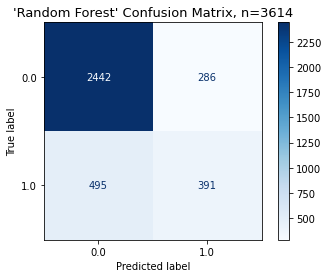

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
con_mat = plot_confusion_matrix(pipe, X_val, y_val, cmap=plt.cm.Blues, ax=ax, values_format='')
# value_format = ''로 설정시에 숫자표기 일반 표기법으로 바뀜

plt.title(f'\'Random Forest\' Confusion Matrix, n={len(y_val)}', fontsize=13)
plt.show()

심각한 과적합 -> 이 모델로 선택한다면 hyperparameter tuning 반드시 필요할듯 

##### XGBoost

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(n_neighbors=23),
    XGBClassifier(random_state=2
                  , n_jobs=-1
                 )
)

pipe.fit(X_train, y_train);

y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)

print(f'훈련 auc score: {roc_auc_score(y_train, y_pred_train)}\n')
print(f'검증 auc score: {roc_auc_score(y_val, y_pred_val)}')
print(f'검증 f1 score: {f1_score(y_val, y_pred_val)}\n')
print(classification_report(y_val, y_pred_val))

훈련 auc score: 0.7138480769309413

검증 auc score: 0.6975711292639495
검증 f1 score: 0.546875

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      2728
         1.0       0.58      0.51      0.55       886

    accuracy                           0.79      3614
   macro avg       0.72      0.70      0.71      3614
weighted avg       0.78      0.79      0.79      3614



Confusion Matrix

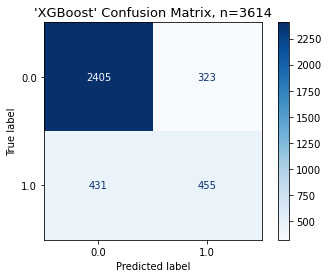

In [ ]:
fig, ax = plt.subplots()
con_mat = plot_confusion_matrix(pipe, X_val, y_val, cmap=plt.cm.Blues, ax=ax, values_format='')


plt.title(f'\'XGBoost\' Confusion Matrix, n={len(y_val)}', fontsize=13)
plt.show()

확실히 RandomForest보다는 과적합을 잘 잡아주는 모델이라서 그런지 훈련데이터와 검증데이터의 성능 차이가 크기 않음  -> XGBoost 모델을 중심으로 다음 분석을 전개할 것

but, 전체적인 성능을 올리기 위한 hyperparamenter tuning 과정이 필요함

+) target 중 1에 대한 precision, recall 모두 매우 낮음 -> data imbalance 때문인듯! 

### Data Imbalance 해결

앞서 언급했듯이 이 데이터는 타겟 값이 0인 샘플의 비율이 75%가 넘어가는 매우 불균형한 데이터임

따라서 과적합을 방지하고, 모델의 성능을 높이기 위해서는 적절하게 비율을 맞춰주는 것이 필요함

<br/>

1) **XGBoost 모델의 hyperparameter를 조정하는 방법**과 2) **Over-Sampling 방식 중 하나인 SMOTE를 사용하는 것** 

중에 검증 데이터의 evaluation score가 더 높은 방식으로 data imbalance를 handling 하려고 함

#### Hyperparameter Tuning: `scale_pos_weight`

In [ ]:
y_train.value_counts()

0.0    10828
1.0     3523
Name: target, dtype: int64

In [ ]:
# scale_pos_weight: minority class에 가중치 부여

# 가중치 계산 방법 = total negative examples (majority class) / total positive examples (minority class)

from collections import Counter
counter = Counter(y_train)

estimate = counter[0] / counter[1]
print(f'estimate: {estimate:.0f}')

estimate: 3


In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(n_neighbors=23),
    XGBClassifier(random_state=2
                  , n_jobs=-1
                 , scale_pos_weight=3)
)

pipe.fit(X_train, y_train);

y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)

print(f'훈련 auc score: {roc_auc_score(y_train, y_pred_train)}\n')
print(f'검증 auc score: {roc_auc_score(y_val, y_pred_val)}')
print(f'검증 f1 score: {f1_score(y_val, y_pred_val)}\n')
print(classification_report(y_val, y_pred_val))

훈련 auc score: 0.7734710977867643

검증 auc score: 0.7690061431323355
검증 f1 score: 0.6236559139784945

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.84      2728
         1.0       0.53      0.75      0.62       886

    accuracy                           0.78      3614
   macro avg       0.72      0.77      0.73      3614
weighted avg       0.82      0.78      0.79      3614



#### Over-Sampling: SMOTE

In [ ]:
y_train.value_counts()

0.0    10828
1.0     3523
Name: target, dtype: int64

In [ ]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

imputer = KNNImputer(n_neighbors=23)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

In [ ]:
X = X_train_imputed
y = y_train

In [ ]:
smote = SMOTE(random_state=2)
X_train_over, y_train_over = smote.fit_sample(X, y)

print('SMOTE 적용 전 train set: ', X.shape, y.shape)
print('SMOTE 적용 후 train set: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 target 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 train set:  (14351, 12) (14351,)
SMOTE 적용 후 train set:  (21656, 12) (21656,)
SMOTE 적용 후 target 분포: 
 1.0    10828
0.0    10828
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


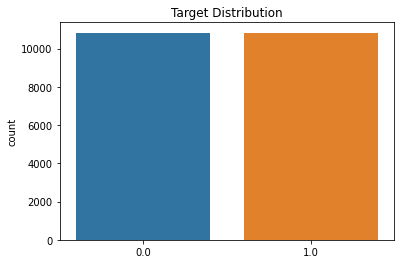

In [ ]:
sns.countplot(x=y_train_over)
plt.title('Target Distribution')
plt.show()

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(n_neighbors=23),
    XGBClassifier(random_state=2
                  , n_jobs=-1
                 )
)

pipe.fit(X_train_over, y_train_over);

y_pred_train = pipe.predict(X_train_over)
y_pred_val = pipe.predict(X_val_imputed)

print(f'훈련 auc score: {roc_auc_score(y_train_over, y_pred_train)}')
print(f'검증 auc score: {roc_auc_score(y_val, y_pred_val)}\n')
print(f'검증 f1 score: {f1_score(y_val, y_pred_val)}\n')
print(classification_report(y_val, y_pred_val))

훈련 auc score: 0.8606852604359069
검증 auc score: 0.7395250657010651

검증 f1 score: 0.6022788931090614

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86      2728
         1.0       0.58      0.63      0.60       886

    accuracy                           0.80      3614
   macro avg       0.73      0.74      0.73      3614
weighted avg       0.80      0.80      0.80      3614




#### 결과 비교



|Evaluation|Hyperparameter Tuning(H)|SMOTE(S)|H - S|
|:--------:|:---:|:---:|:---:|
|roc_auc_score|0.77|0.74|+ 0.03|
|f1_score|0.63|0.60|+ 0.03|

---

-> 성능이 더 좋은 **hyperparameter tuning**하여 data imbalance handling 하기로 결정



### Hyperparameter Tuning

Data Imbalance 해결했으니, 본격적으로 모델의 성능을 높이기 위한 hyperparameter tuning 진행

<br/>

주의할 점!

XGBoost 모델은 다른 모델에 비해 hyperparameter tuning에 민감하므로 여러번 시도해보기

In [ ]:
# 최적의 max_depth, learning_rate 찾기
estimator = XGBClassifier(
    random_state=2
    , n_jobs=-1
    , scale_pos_weight=3
)

params = {
    'max_depth': [3, 5, 7]
    , 'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train_imputed, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   38.4s finished


{'learning_rate': 0.1, 'max_depth': 7}


In [ ]:
# 최적의 n_estimators 찾기
processor = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(n_neighbors=23)
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)
X_test_processed = processor.transform(X_test)

model = XGBClassifier(
    n_estimators=1000  
    , max_depth=7      
    , learning_rate=0.1
    , scale_pos_weight=3 
    , n_jobs=-1
    , random_state=2
)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model.fit(X_train_processed, y_train, 
          eval_set=eval_set,
          eval_metric='auc', 
          early_stopping_rounds=50
         ) 

# 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-auc:0.816985	validation_1-auc:0.776288
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.821884	validation_1-auc:0.78432
[2]	validation_0-auc:0.8268	validation_1-auc:0.787513
[3]	validation_0-auc:0.831656	validation_1-auc:0.785855
[4]	validation_0-auc:0.834588	validation_1-auc:0.787735
[5]	validation_0-auc:0.835385	validation_1-auc:0.790155
[6]	validation_0-auc:0.837076	validation_1-auc:0.789443
[7]	validation_0-auc:0.83959	validation_1-auc:0.791492
[8]	validation_0-auc:0.841829	validation_1-auc:0.791887
[9]	validation_0-auc:0.843586	validation_1-auc:0.791019
[10]	validation_0-auc:0.84661	validation_1-auc:0.791815
[11]	validation_0-auc:0.849526	validation_1-auc:0.791291
[12]	validation_0-auc:0.851563	validation_1-auc:0.791777
[13]	validation_0-auc:0.852951	validation_1-auc:0.79027
[14]	validation_0-auc:0.854377	validation_1-auc:0.789835
[15]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print('검증 정확도', model.score(X_val_processed, y_val))

print(classification_report(y_val, model.predict(X_val_processed)))

검증 정확도 0.7847260653016048
              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      2728
         1.0       0.55      0.73      0.62       886

    accuracy                           0.78      3614
   macro avg       0.72      0.77      0.74      3614
weighted avg       0.81      0.78      0.79      3614



In [ ]:
# 최적의 나무 수 
model.best_ntree_limit

34

#### 최종 모델

In [ ]:
opt_pipe = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(n_neighbors=23),
    XGBClassifier(n_estimators=30
                  , max_depth=7        
                  , learning_rate=0.1
                  , scale_pos_weight=3 
                  , n_jobs=-1
                  , random_state=2
                     )
)

opt_pipe.fit(X_train, y_train);

y_pred_train = opt_pipe.predict(X_train)
y_pred_val = opt_pipe.predict(X_val)

print(f'훈련 auc score: {roc_auc_score(y_train, y_pred_train)}\n')
print(f'검증 auc score: {roc_auc_score(y_val, y_pred_val)}')
print(f'검증 f1 score: {f1_score(y_val, y_pred_val)}\n')

print(classification_report(y_val, y_pred_val))

훈련 auc score: 0.8034729112955645

검증 auc score: 0.7672647339189611
검증 f1 score: 0.625784645098986

              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      2728
         1.0       0.55      0.73      0.63       886

    accuracy                           0.79      3614
   macro avg       0.72      0.77      0.74      3614
weighted avg       0.81      0.79      0.79      3614



아무런 파라미터 조정을 하지 않았을 때보다 auc score, f1 score 모두 상승함

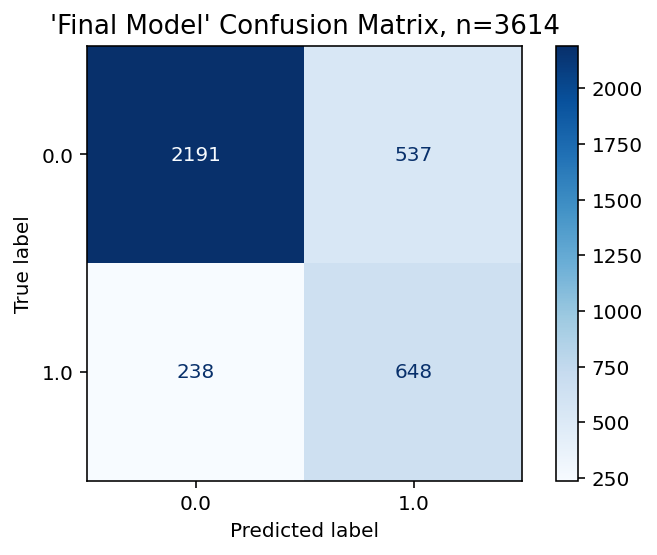

In [ ]:
fig, ax = plt.subplots()
con_mat = plot_confusion_matrix(opt_pipe, X_val, y_val, cmap=plt.cm.Blues, ax=ax, values_format='')

plt.rcParams['figure.dpi'] = 144
plt.title(f'\'Final Model\' Confusion Matrix, n={len(y_val)}', fontsize=13)
plt.show()

test set 검증

In [ ]:
class_index = 1
y_pred_proba = opt_pipe.predict_proba(X_test)[:,class_index]
print(f'Test AUC for class "{opt_pipe.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba))

Test AUC for class "1.0":
0.7824024673854917


In [ ]:
y_pred = opt_pipe.predict(X_test)

print(f'테스트 auc score: {roc_auc_score(y_test, y_pred)}')
print(f'테스트 f1 score: {f1_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

테스트 auc score: 0.7653546244823339
테스트 f1 score: 0.6463815789473685

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      1470
         1.0       0.59      0.72      0.65       547

    accuracy                           0.79      2017
   macro avg       0.74      0.77      0.75      2017
weighted avg       0.80      0.79      0.79      2017



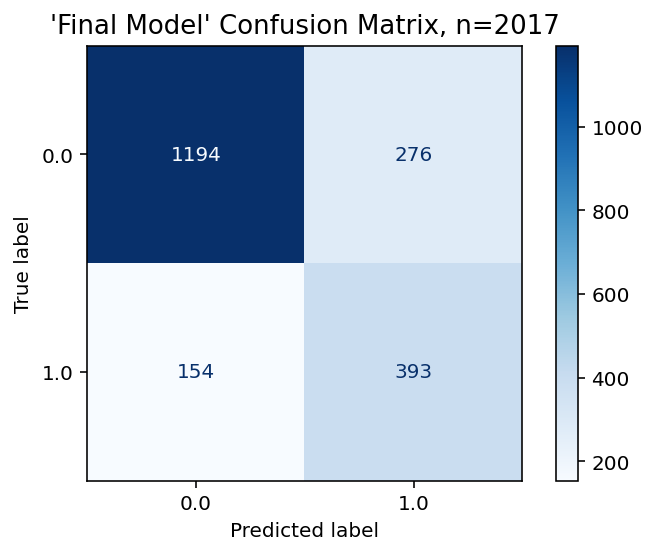

In [ ]:
fig, ax = plt.subplots()
con_mat = plot_confusion_matrix(opt_pipe, X_test, y_test, cmap=plt.cm.Blues, ax=ax, values_format='')

plt.rcParams['figure.dpi'] = 144
plt.title(f'\'Final Model\' Confusion Matrix, n={len(y_test)}', fontsize=13)
plt.show()


확실히 hyperparameter tuning하기 전보다 타겟 1을 맞추는 비율이 늘었음

#### 특성 중요도

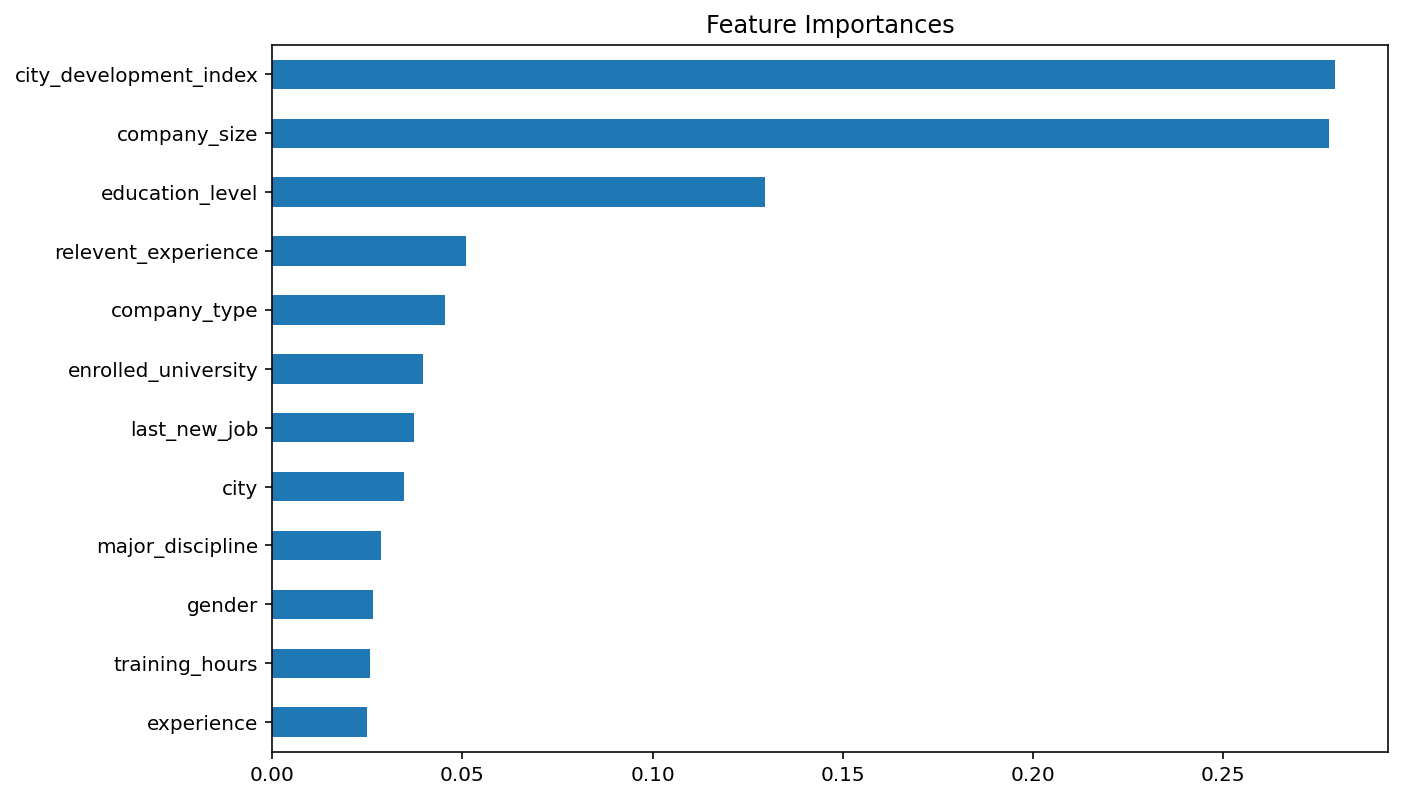

In [ ]:
xg = opt_pipe.named_steps['xgbclassifier']

importances = pd.Series(xg.feature_importances_, X_train.columns)

n = 13

plt.rcParams['figure.dpi'] = 144
plt.figure(figsize=(10,n/2))
plt.title('Feature Importances')
importances.sort_values()[-n:].plot.barh()
plt.show()

In [ ]:
len(X_train['city_development_index'].value_counts())

93

feature 별 모델에 대한 중요도를 나타냄.

BUT, high cardinality feature의 경우 트리 구성 중 상위 노드에 위치할 확률이 높아 모델이 **과적합**될 수 있으므로 중요도를 그대로 해석하는 것은 위험

이 데이터셋의 경우 제일 중요도가 높게 나온 `city_development_index` feature의 경우 93개의 unique value로 구성되어 매우 높은 cardinality 가짐

#### 순열 중요도

In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 5.3 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.pipeline import Pipeline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pipe = Pipeline([
                 ('preprocessing', make_pipeline(OrdinalEncoder(), KNNImputer(n_neighbors=23)))
                 , ('xg', XGBClassifier(
                     n_estimators=30
                     , max_depth=7        
                     , learning_rate=0.1
                     , scale_pos_weight=3 
                     , n_jobs=-1
                     , random_state=2))
])

pipe.fit(X_train, y_train);

In [ ]:
permuter = PermutationImportance(
    pipe.named_steps['xg']
    , scoring='roc_auc'
    , n_iter=5
    , random_state=2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [ ]:
feature_names = X_val.columns.tolist()

In [ ]:
# validation set permutation importance
eli5.show_weights(
    permuter
    , top=None
    , feature_names=feature_names
)

Weight,Feature
0.1790 ± 0.0180,city_development_index
0.0678 ± 0.0042,company_size
0.0335 ± 0.0025,company_type
0.0103 ± 0.0063,education_level
0.0033 ± 0.0022,enrolled_university
0.0024 ± 0.0016,last_new_job
0.0024 ± 0.0048,training_hours
0.0016 ± 0.0025,experience
0.0016 ± 0.0030,city
-0.0006 ± 0.0063,relevent_experience


In [ ]:
# test data permutation importance
X_test_transformed = pipe.named_steps['preprocessing'].transform(X_test)

permuter.fit(X_test_transformed, y_test);

feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter
    , top=None
    , feature_names=feature_names
)

Weight,Feature
0.1756 ± 0.0220,city_development_index
0.0663 ± 0.0075,company_size
0.0263 ± 0.0042,company_type
0.0070 ± 0.0038,relevent_experience
0.0058 ± 0.0051,education_level
0.0040 ± 0.0028,experience
0.0021 ± 0.0067,city
0.0013 ± 0.0070,last_new_job
0.0011 ± 0.0047,enrolled_university
-0.0003 ± 0.0023,gender


순열 중요도: 

각각의 특성들이 target에 얼마나 영향을 미치는지를 보여줌

중요도를 알고싶은 특성값에 노이즈를 만든 후 모델의 예측 오차 증가량을 계산하여 특성값의 중요도를 측정하는 것 

<br/>

-> 만약 이 때 모델 오차가 증가한다면 이 특성값은 '중요한 것', 모델 오차의 차이가 미미하다면 '중요하지 않다'고 할 수 있음

##### Feature Selection


In [ ]:
print(f'before feature selection: {X_train.shape, X_val.shape}')

before feature selection: ((14351, 12), (3614, 12))


In [ ]:
minimum_importance = 0.0001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

In [ ]:
print(f'after feature selection: {X_train_selected.shape, X_val_selected.shape}')

after feature selection: ((14351, 9), (3614, 9))


In [ ]:
pipeline = Pipeline([
                 ('preprocessing', make_pipeline(OrdinalEncoder(),KNNImputer(n_neighbors=23)))
                 , ('xg', XGBClassifier(
                     n_estimators=30
                     , max_depth=7        
                     , learning_rate=0.1
                     , scale_pos_weight=3 
                     , n_jobs=-1
                     , random_state=2))
])

pipeline.fit(X_train_selected, y_train);

In [ ]:
y_pred_train = pipeline.predict(X_train_selected)
y_pred_val = pipeline.predict(X_val_selected)

print(f'훈련 auc score: {roc_auc_score(y_train, y_pred_train)}\n')
print(f'검증 auc score: {roc_auc_score(y_val, y_pred_val)}')
print(f'검증 f1 score: {f1_score(y_val, y_pred_val)}\n')

print(classification_report(y_val, y_pred_val))

훈련 auc score: 0.8003227196319589

검증 auc score: 0.7673516181990294
검증 f1 score: 0.6243436754176611

              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      2728
         1.0       0.54      0.74      0.62       886

    accuracy                           0.78      3614
   macro avg       0.72      0.77      0.74      3614
weighted avg       0.81      0.78      0.79      3614



feature selection 이전 score

- 검증 auc score: 0.7723002985509355

- 검증 f1 score: 0.632495164410058

<br/>

feature selection 전 후로 score 크게 차이나지는 않음

-> 분석에 사용되는 feature가 많아지면, cost 증가: score 크게 차이나지 않는다면 feature 수를 줄이는 것도 하나의 방법이 될 수 있음 

In [ ]:
y_pred = pipe.predict(X_test)

print(f'테스트 auc score: {roc_auc_score(y_test, y_pred)}')
print(f'테스트 f1 score: {f1_score(y_test, y_pred)}\n')

print(classification_report(y_test, y_pred))

테스트 auc score: 0.7653546244823339
테스트 f1 score: 0.6463815789473685

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      1470
         1.0       0.59      0.72      0.65       547

    accuracy                           0.79      2017
   macro avg       0.74      0.77      0.75      2017
weighted avg       0.80      0.79      0.79      2017



In [ ]:
y_pred = pipeline.predict(X_test_selected)

print(f'테스트 auc score: {roc_auc_score(y_test, y_pred)}')
print(f'테스트 f1 score: {f1_score(y_test, y_pred)}\n')

print(classification_report(y_test, y_pred))

테스트 auc score: 0.7587434242435549
테스트 f1 score: 0.637633525061627

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84      1470
         1.0       0.58      0.71      0.64       547

    accuracy                           0.78      2017
   macro avg       0.73      0.76      0.74      2017
weighted avg       0.80      0.78      0.79      2017



### 모델 해석

In [ ]:
!pip install PDPbox
!pip install shap

     |████████████████████████████████| 34.0 MB 40 kB/s 
     |████████████████████████████████| 13.1 MB 6.5 kB/s 
  Created wheel for PDPbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=1c589894260112f6fe673f0f085b0fd7e4ff227ad1cc87a3df58419c5e40ca93
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built PDPbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.13.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 356 kB 5.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491654 sha256=3734ade4e87d7c94497bb5cea82e85514728edc2eb2206b7a8c8c82aac54af00
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [ ]:
ordinal_cols_mapping = [
                        {'col':'company_size',
                         'mapping': {'<10':0,
                                     '10/49':1, 
                                     '50-99':2, 
                                     '100-500':3, 
                                     '500-999':4, 
                                    '1000-4999':5, 
                                    '5000-9999':6, 
                                    '10000+':7
                                     }},
                        {'col': 'company_type',
                         'mapping': {'Pvt Ltd':0,
                                     'Funded Startup':1, 
                                     'Early Stage Startup':2, 
                                     'Other':3, 
                                     'Public Sector':4, 
                                     'NGO':5}},
                        {'col': 'relevent_experience',
                         'mapping':{'Has relevent experience': 1,
                                    'No relevent experience': 0}},
                        {'col': 'enrolled_university',
                         'mapping': {'no_enrollment': 0,
                                     'Full time course': 2, 
                                     'Part time course': 1 }},
                        {'col': 'education_level',
                         'mapping': {'Primary School' : 0,
                                     'Graduate' : 2,
                                     'Masters':3, 
                                     'High School':1, 
                                     'Phd':4}},
                        {'col': 'last_new_job',
                         'mapping': {'never':0,
                                     '1':1, 
                                     '2':2, 
                                     '3':3, 
                                     '4':4, 
                                     '>4':5}},
                        {'col':'experience',
                         'mapping':{'<1':0,
                                    '1':1, 
                                    '2':2, 
                                    '3':3, 
                                    '4':4, 
                                    '5':5,
                                    '6':6,
                                    '7':7,
                                    '8':8, 
                                    '9':9, 
                                    '10':10, 
                                    '11':11,
                                    '12':12,
                                    '13':13, 
                                    '14':14, 
                                    '15':15, 
                                    '16':16,
                                    '17':17,
                                    '18':18,
                                    '19':19, 
                                    '20':20, 
                                    '>20':21}}
                        
]

In [ ]:
df = pd.concat([X_train_selected, y_train], axis=1)
df = df.dropna()
X_train_selected = df.drop('target', axis=1)
y_train_selected = df['target']

In [ ]:
final_pipe = make_pipeline(
    OrdinalEncoder(mapping=ordinal_cols_mapping),
    XGBClassifier( n_estimators=30
                  , max_depth=7       
                  , learning_rate=0.1
                  , scale_pos_weight=3 
                  , n_jobs=-1
                  , random_state=2)
)

final_pipe.fit(X_train_selected, y_train_selected);

#### PDP 1특성

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


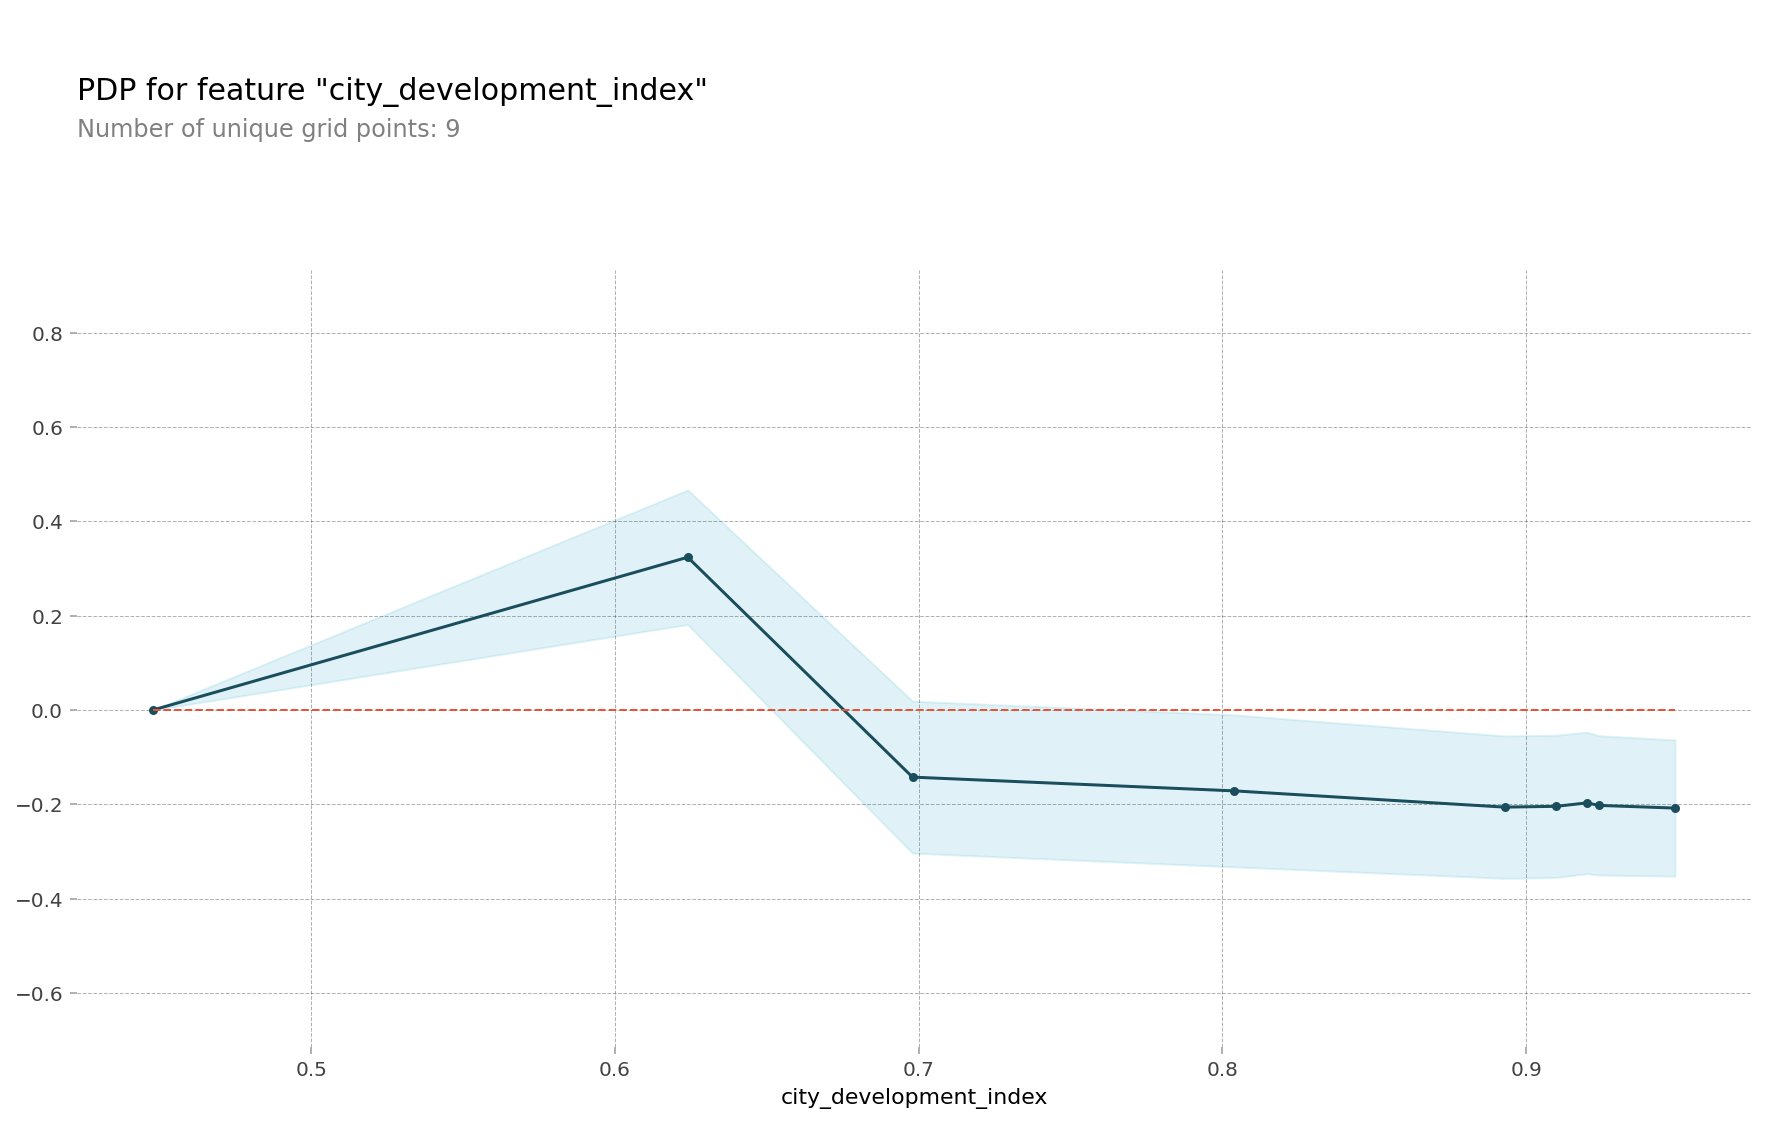

In [ ]:
# city_development_index
encoder = final_pipe.named_steps['ordinalencoder']

X_encoded = encoder.fit_transform(X_test_selected)
xg = final_pipe.named_steps['xgbclassifier']

from pdpbox import pdp

features = X_train_selected.columns
feature = 'city_development_index'

pdp_dist = pdp.pdp_isolate(model=xg, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

index값이 약 0.62정도 까지는 이직 선호에 긍정적인 영향을 미치나, 이후로는 도시발전 정도가 이직 희망 여부에 영향을 미치지 않음

city_development_index = 도시 발전 정도를 표준화된 수치로 나타낸 것 -> 수치가 1에 가까울수록 발전된 도시

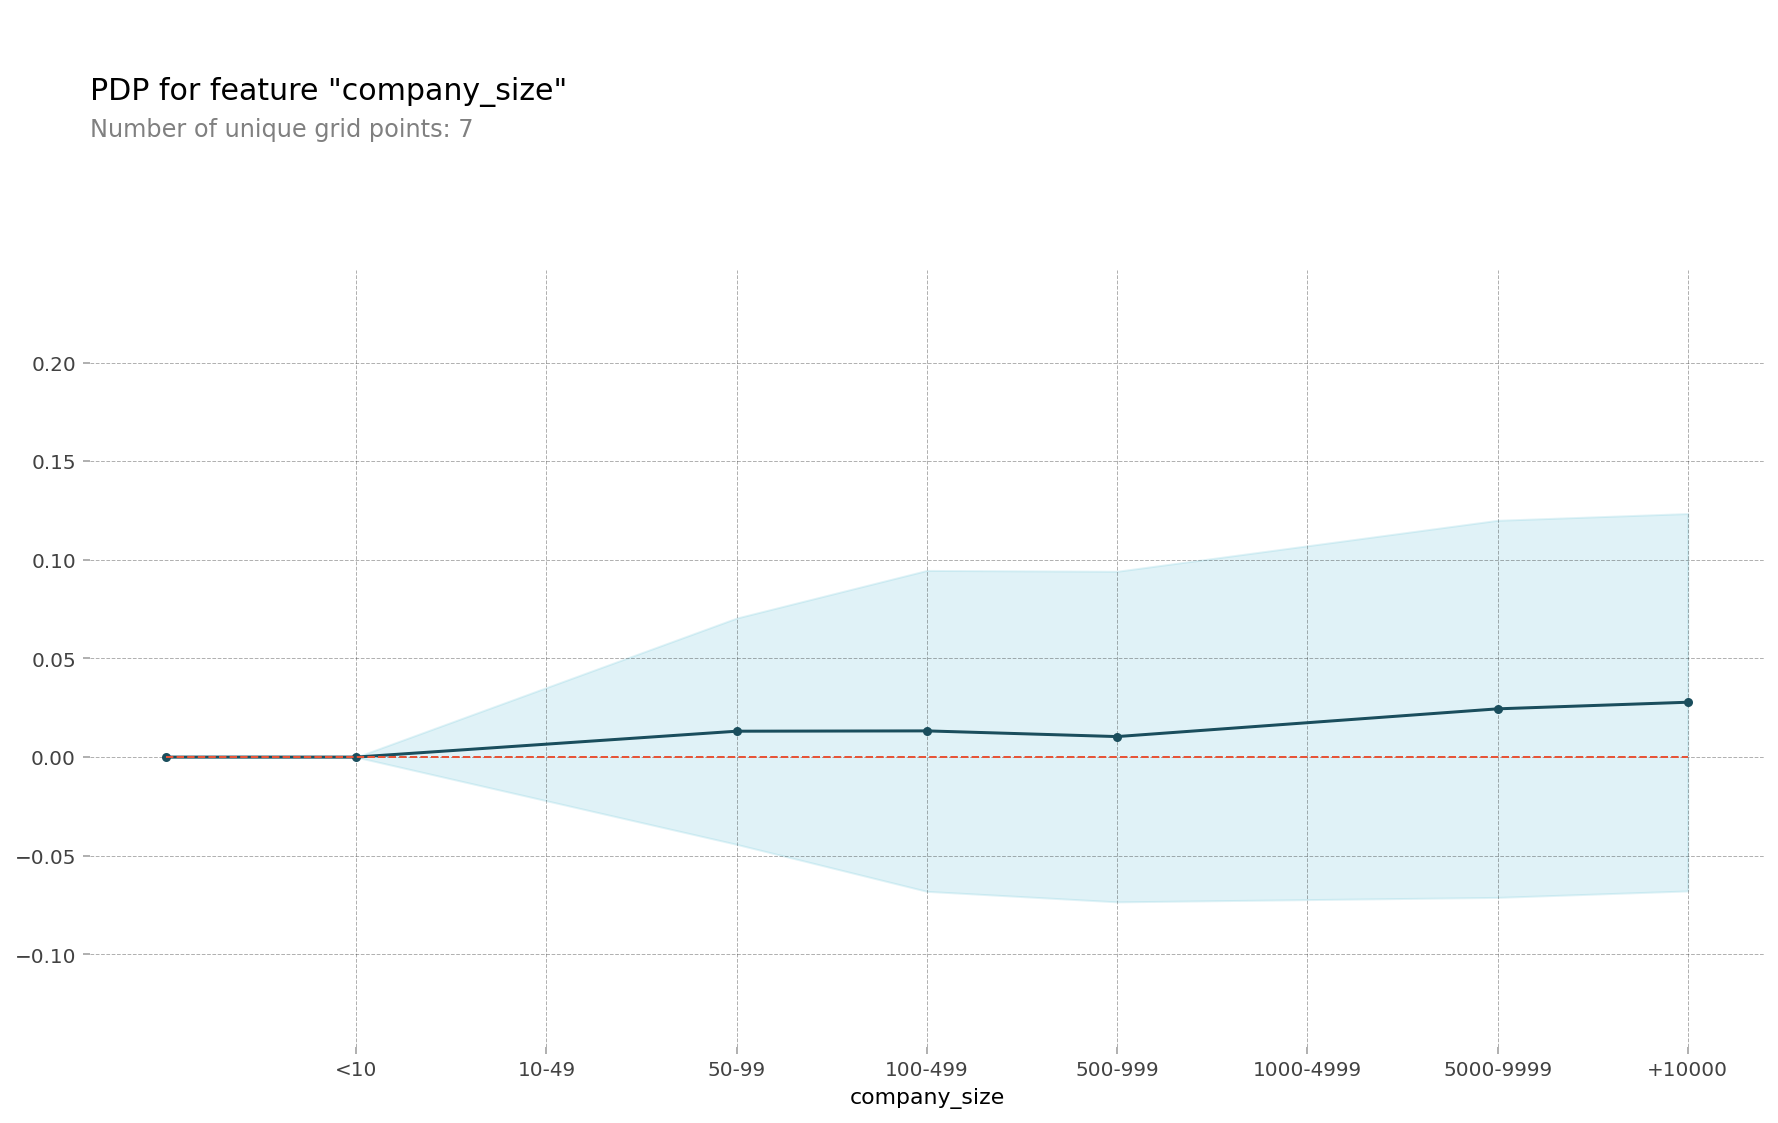

In [ ]:
# company_size
features = X_train_selected.columns
feature = 'company_size'

pdp_dist = pdp.pdp_isolate(model=xg, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([0,1,2,3,4,5,6,7],['<10','10-49','50-99','100-499','500-999','1000-4999','5000-9999','+10000']);

전체적으로 회사의 규모가 커질수록 이직 선호도에 긍정적 영향을 미치는 것으로 보임 

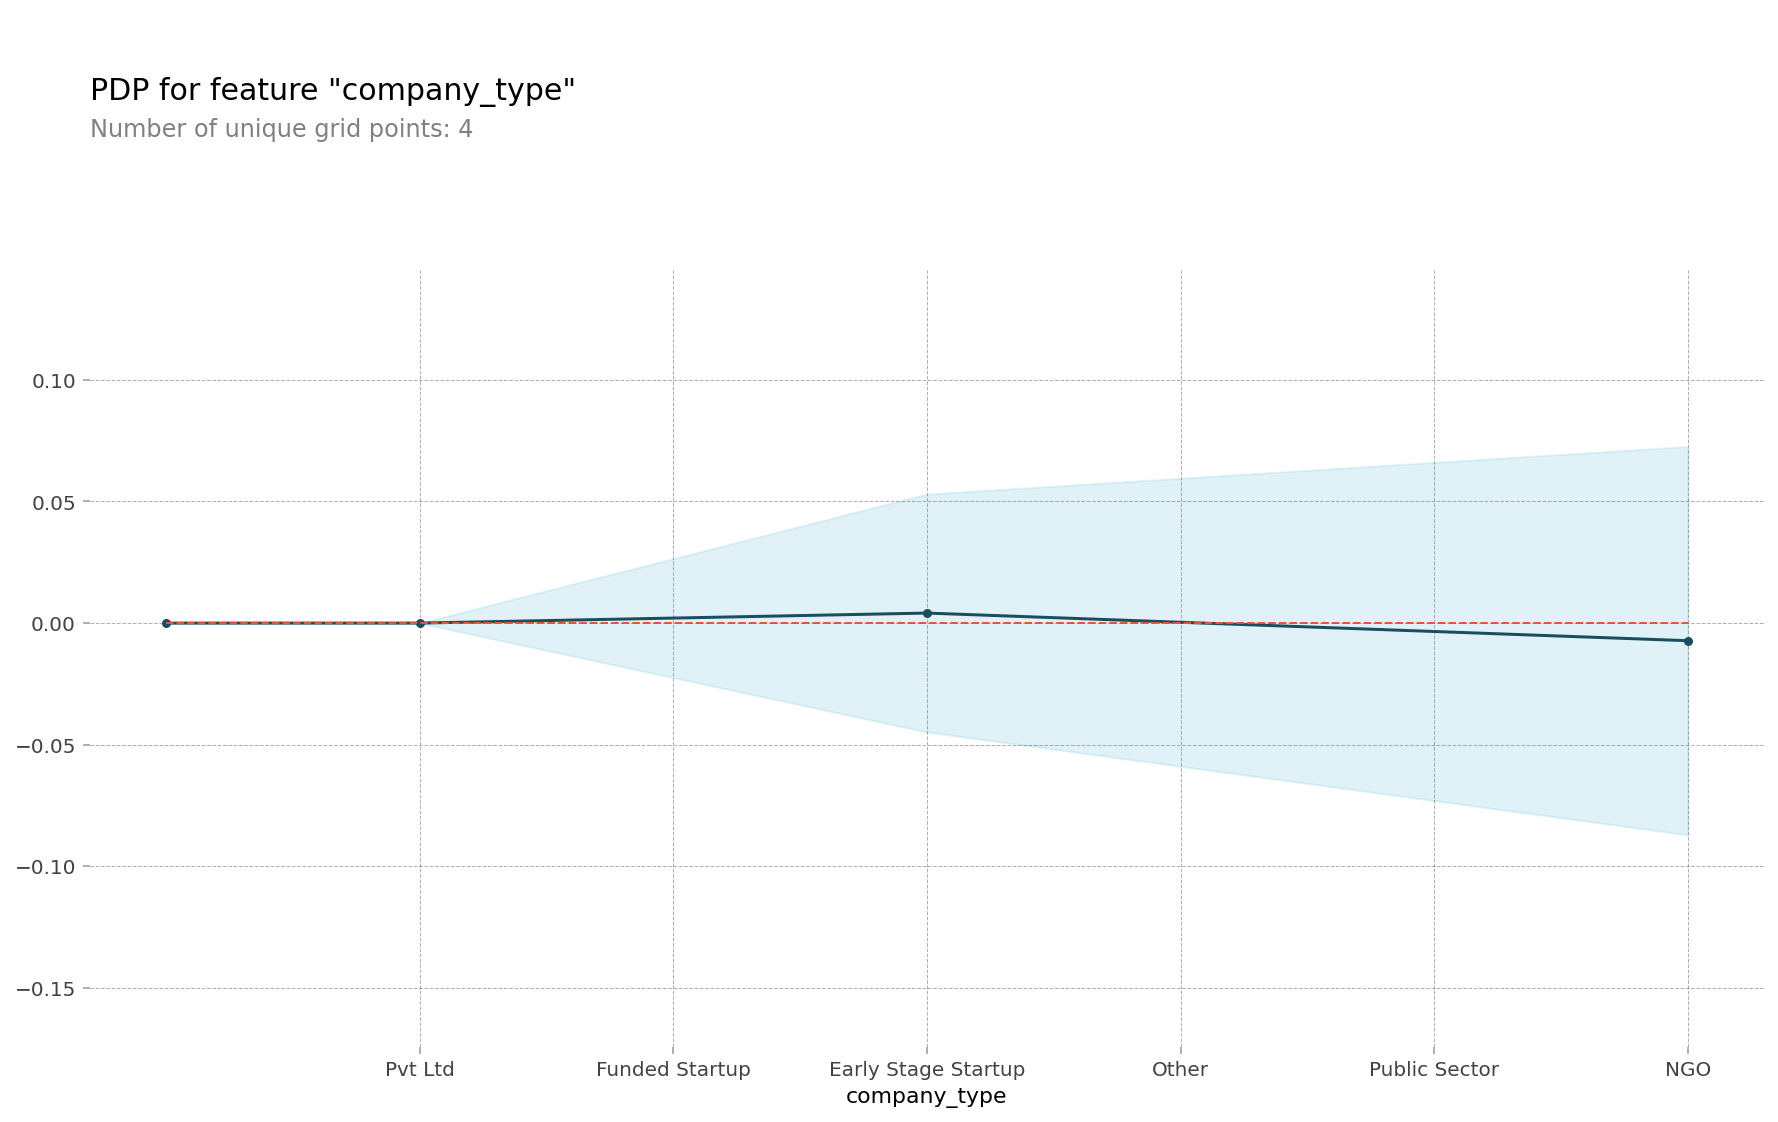

In [ ]:
# company_type
features = X_train_selected.columns
feature = 'company_type'

pdp_dist = pdp.pdp_isolate(model=xg, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([0,1,2,3,4,5],['Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO']);


NGO에 다니는 사람들의 경우 비교적 이직하지 않을 확률이 높다는 것 외에는 두드러지는 양상은 보이지 않고 있음 (other 부문의 확률이 높기는 하지만, 기타 부문을 합쳐놓은 것이라 유의미하다고 볼 수 없음)

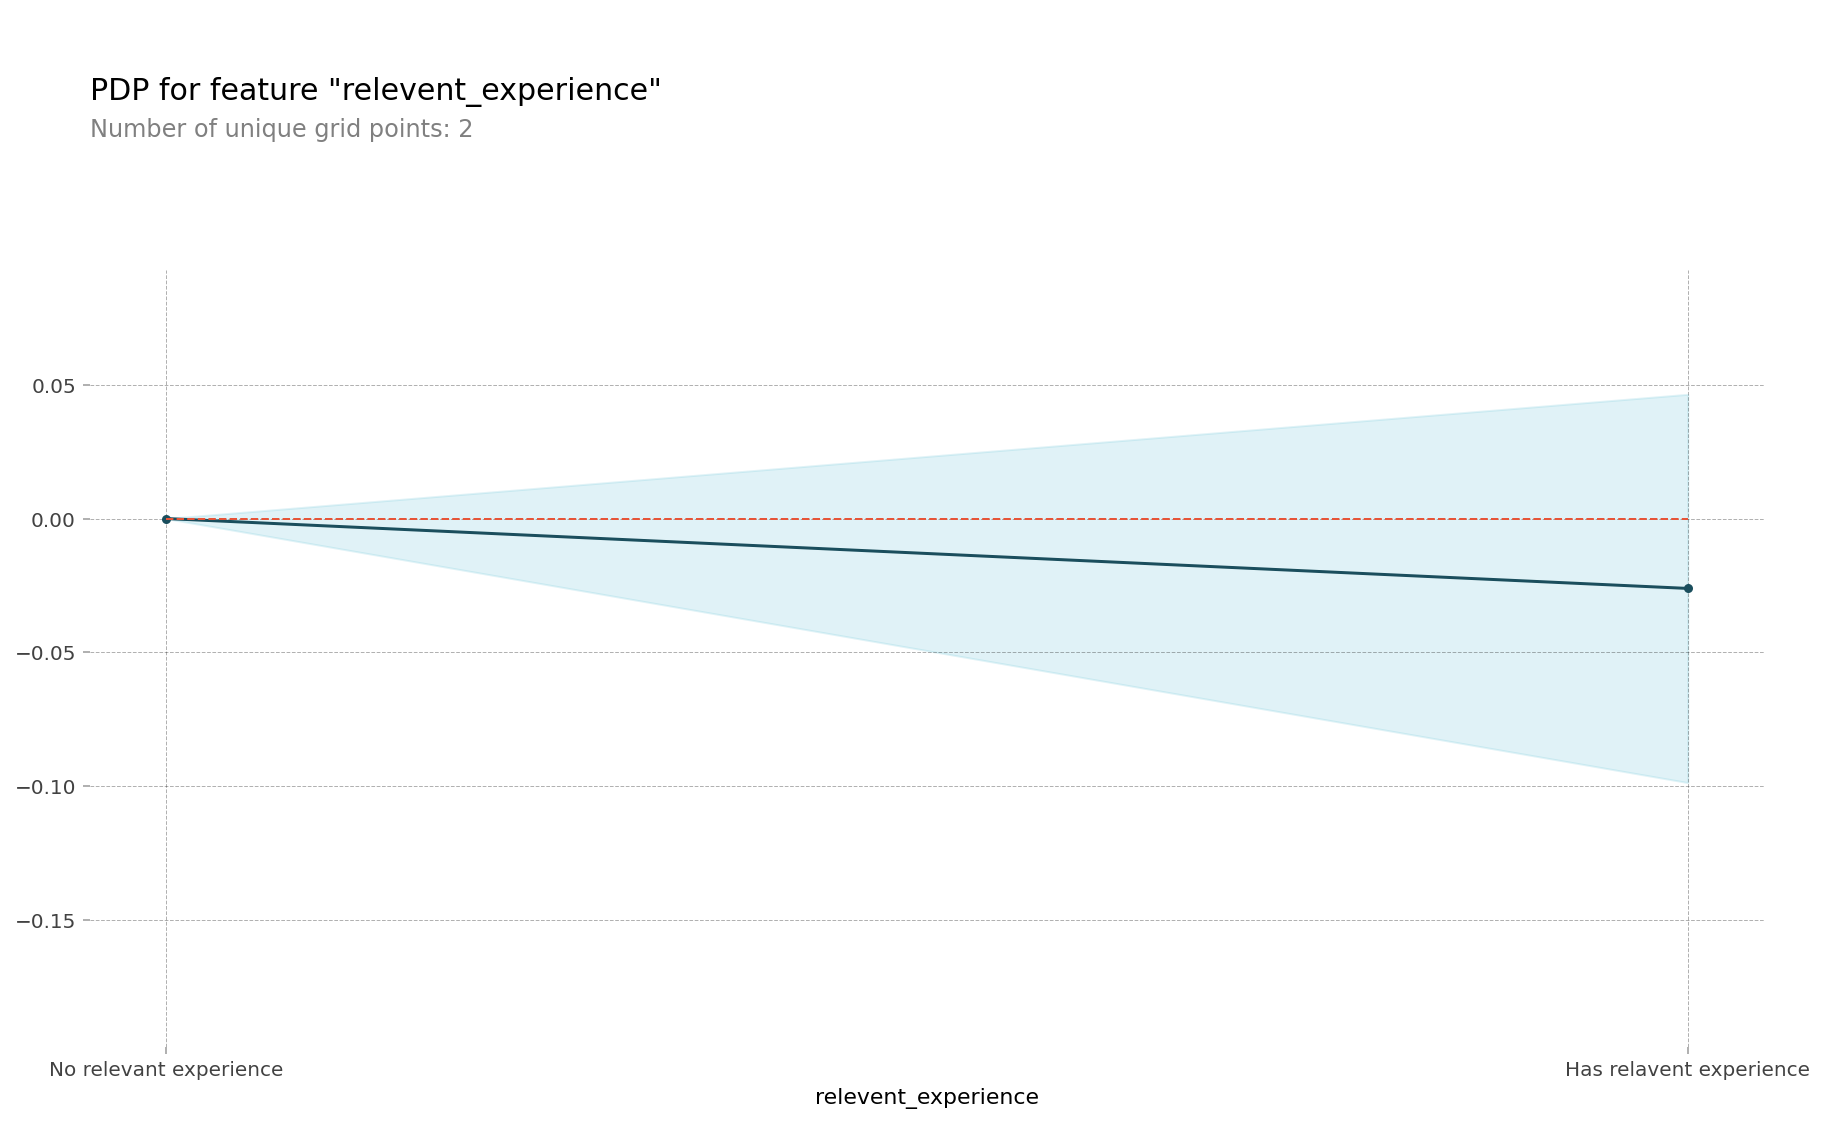

In [ ]:
# relevant_experience
features = X_train_selected.columns
feature = 'relevent_experience'

pdp_dist = pdp.pdp_isolate(model=xg, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([0,1],['No relevant experience','Has relavent experience']);

데이터 사이언스 관련 경험이 있는 경우 이직을 고려할 확률이 더 낮음

-> 아마 이미 데이터 사이언스 분야에 종사하고 있거나, 경험이 있기 때문에 '이직'에 대한 흥미가 떨어질수도..

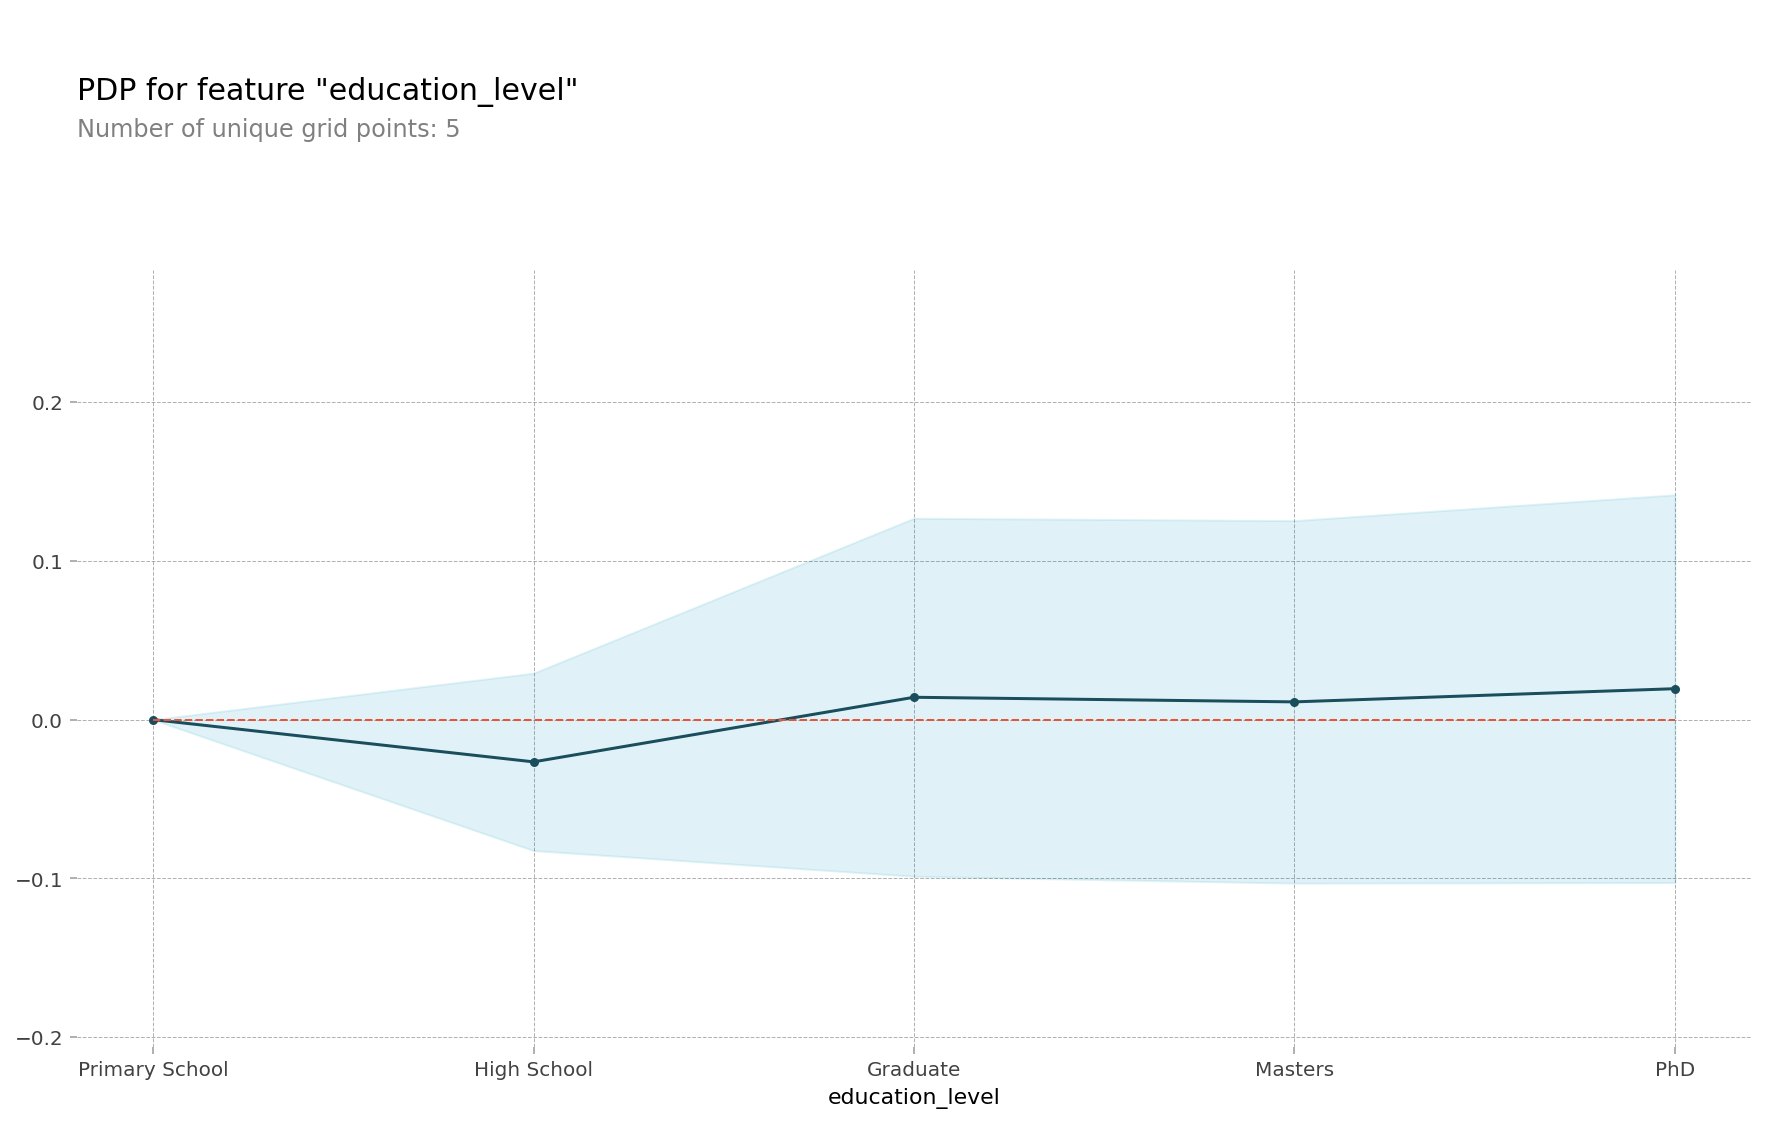

In [ ]:
# education_level
features = X_train_selected.columns
feature = 'education_level'

pdp_dist = pdp.pdp_isolate(model=xg, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([0,1,2,3,4],['Primary School', 'High School', 'Graduate', 'Masters', 'PhD']);


전체적으로 최종 학력이 높을수록 데이터사이언티스트로 이직을 고려할 확률이 비교적 높음

#### SHAP

In [ ]:
test_p = pd.DataFrame({
    'pred_proba': y_pred_proba,
    'status': y_test
})

test_p = pd.concat([test_p, X_test], axis=1)

In [ ]:
test_p.head()

,pred_proba,status,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.155787,1.0,35,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,0.160587,0.0,5,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,0.698925,1.0,16,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,0.168415,0.0,54,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,0.247119,1.0,5,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


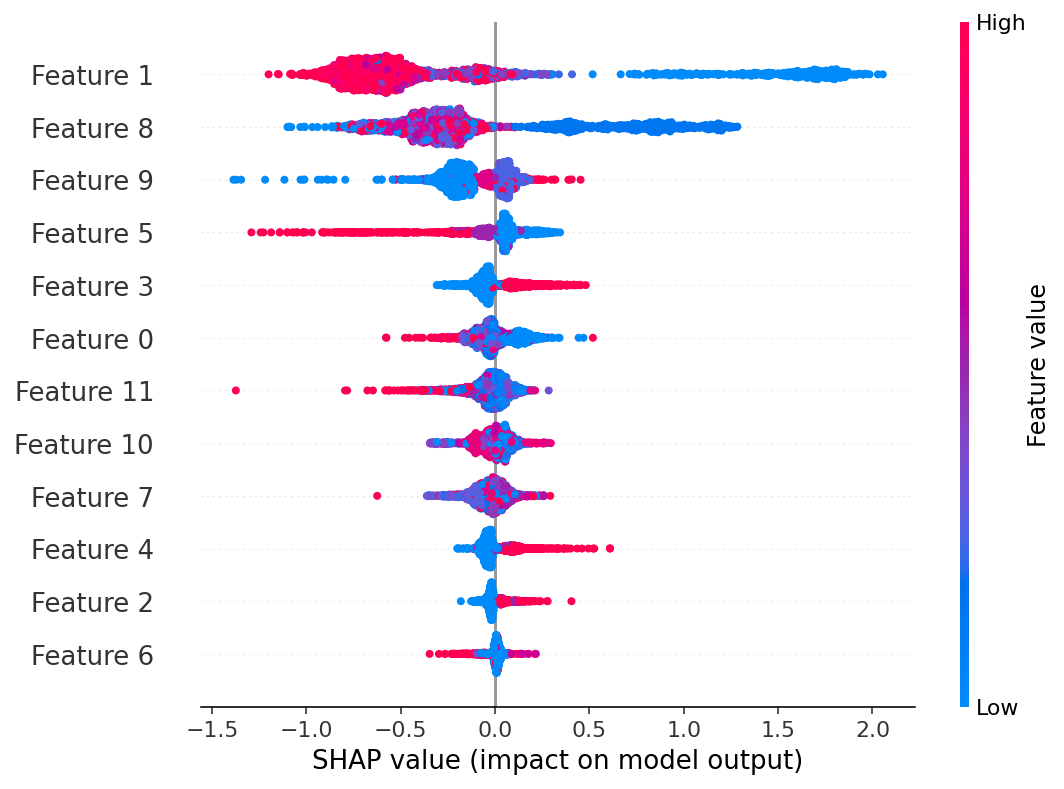

In [ ]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed)

In [ ]:
X_test.columns

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'],
      dtype='object')

**TOP 5 Feature**

Feature 1: city_development_index

Feature 8: company_size

Feature 9: company_type

Feature 5: education_level

Feature 3: relevant_experience



---

Target 1로 제대로 예측한 case를 분석하여 각각의 feature가 어떠한 방향으로 target을 결정하는데 영향을 미쳤는지 확인해보자

In [ ]:
interested = test_p['status'] == 1
not_interested = ~interested
right = (interested) == (test_p['pred_proba'] > 0.50)
wrong = ~right

In [ ]:
test_p[interested & right].sort_values(by='pred_proba', ascending=False).head(1)

,pred_proba,status,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
1629,0.866029,1.0,16,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,4,NaN,NaN,1,53


In [ ]:
row = X_test.iloc[[250]]
row

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
250,17,0.527,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,10/49,Pvt Ltd,1,4


In [ ]:
explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' 
)


proba를 상승시키는 요인으로는 `city_development_index`, `education_level`:Graduate, `training_hours`:4가 주요한 역할을 담당하며,

proba를 하락시키는 요인으로는 `company_type`:Pvt Ltd, `company_size`:10-49가 주요한 영향을 미친 것으로 나타남

<br/>

다만 이는 한개의 케이스를 자세히 들여다본 것이므로, 이 특성들이 모든 sample에서 이러한 영향력을 가진다고는 볼 수 없음 => 더 면밀한 분석이 필요함

---

전체적으로 `city_development_index`, `company_type`, `company_size`와 같은 환경적인 부분과 `education_level`, `relevant_experience`와 같은 개인적인 부분이 모두 이직 희망 여부에 영향을 미침

+) 전체적으로 이직 희망 비율이 낮은데 이를 어떻게 높일 것인지에 대해 고민해야 할 필요가 있음